In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofweek, hour, col, date_format
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
from sklearn.decomposition import PCA as sk_PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# Adiciona o pacote spark-excel ao iniciar a sessão Spark
spark = SparkSession.builder \
    .appName("Clustering") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

24/07/30 07:02:32 WARN Utils: Your hostname, MacBook-Pro-de-Julia.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
24/07/30 07:02:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/kikuye/.ivy2/cache
The jars for the packages stored in: /Users/kikuye/.ivy2/jars
com.crealytics#spark-excel_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ac7923e7-9b9a-45c8-a7e0-4e135698b069;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/spark-3.5.1/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.crealytics#spark-excel_2.12;0.13.5 in central
	found org.apache.poi#poi;4.1.2 in central
	found commons-codec#commons-codec;1.13 in central
	found org.apache.commons#commons-collections4;4.4 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found com.zaxxer#SparseBitSet;1.2 in central
	found org.apache.poi#poi-ooxml;4.1.2 in central
	found org.apache.poi#poi-ooxml-schemas;4.1.2 in central
	found org.apache.xmlbeans#xmlbeans;3.1.0 in central
	found com.github.virtuald#curvesapi;1.06 in central
	found com.norbitltd#spoiwo_2.12;1.7.0 in central
	found org.scala-lang.modules#scala-xml_2.12;1.2.0 in central
	found com.github.pjfanning#excel-streaming-reader;2.3.4 in central
	found com.github.pjfanning#poi-shared-strings;1.0.4 in central
	found com.h2database#h2;1.4.200 in central
	found org.apache.commons#commons-text;1.8 in central
	found org.apache.commons#commons-lang3;3.9 in central
	found xml-apis#xml-apis;1.4.01 in central
	found org.slf4j#slf4j-api;1.7.3

In [5]:
# Carrega o arquivo Excel diretamente para um DataFrame do Spark
file_path = '../data/Coffee Shop Sales.xlsx'
spark_df = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

In [6]:
spark_df.limit(5).toPandas()

24/07/30 07:02:44 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/07/30 07:02:50 WARN TaskSetManager: Stage 1 contains a task of very large size (2706 KiB). The maximum recommended task size is 1000 KiB.


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1.0,2023-01-01,1899-12-31 07:06:39,2.0,5.0,Lower Manhattan,32.0,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2.0,2023-01-01,1899-12-31 07:09:24,2.0,5.0,Lower Manhattan,57.0,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3.0,2023-01-01,1899-12-31 07:14:32,2.0,5.0,Lower Manhattan,59.0,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4.0,2023-01-01,1899-12-31 07:20:52,1.0,5.0,Lower Manhattan,22.0,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5.0,2023-01-01,1899-12-31 07:23:09,2.0,5.0,Lower Manhattan,57.0,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [9]:
# Extrai a parte do tempo corretamente da coluna `transaction_time`
spark_df = spark_df.withColumn('transaction_time', date_format(col('transaction_time'), 'HH:mm:ss'))

# Cria colunas day_of_week e hour_of_day
spark_df = spark_df.withColumn('day_of_week', dayofweek(col('transaction_date')))
spark_df = spark_df.withColumn('hour_of_day', hour(col('transaction_time')))

# Cria coluna total_value
spark_df = spark_df.withColumn('total_value', col('transaction_qty') * col('unit_price'))

In [10]:
spark_df.limit(5).toPandas()

24/07/30 07:03:38 WARN TaskSetManager: Stage 3 contains a task of very large size (2706 KiB). The maximum recommended task size is 1000 KiB.


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,day_of_week,hour_of_day,total_value
0,1.0,2023-01-01,07:06:11,2.0,5.0,Lower Manhattan,32.0,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,1,7,6.0
1,2.0,2023-01-01,07:08:56,2.0,5.0,Lower Manhattan,57.0,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,7,6.2
2,3.0,2023-01-01,07:14:04,2.0,5.0,Lower Manhattan,59.0,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,1,7,9.0
3,4.0,2023-01-01,07:20:24,1.0,5.0,Lower Manhattan,22.0,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,1,7,2.0
4,5.0,2023-01-01,07:22:41,2.0,5.0,Lower Manhattan,57.0,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,7,6.2


In [11]:
# Codificação das variáveis categóricas
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") 
            for column in ['product_id', 'store_id', 'day_of_week', 'product_category', 'product_type']]

for indexer in indexers:
    spark_df = indexer.fit(spark_df).transform(spark_df)

In [12]:
encoder = OneHotEncoder(
    inputCols=['product_id_index', 'store_id_index', 'day_of_week_index', 'product_category_index', 'product_type_index'], 
    outputCols=['product_id_vec', 'store_id_vec', 'day_of_week_vec', 'product_category_vec', 'product_type_vec'])
spark_df = encoder.fit(spark_df).transform(spark_df)

In [13]:
# Monta o vetor de features
assembler = VectorAssembler(inputCols=[
    'product_id_vec', 
    'store_id_vec', 
    'day_of_week_vec', 
    'product_category_vec', 
    'product_type_vec',
    'hour_of_day', 
    'transaction_qty', 
    'unit_price',
    'total_value'], outputCol='features')
spark_df = assembler.transform(spark_df)

In [14]:
# Normalização
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
features_df = scaler.fit(spark_df).transform(spark_df)

24/07/30 07:04:26 WARN TaskSetManager: Stage 19 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


In [15]:
# Função para treinar KMeans e visualizar clusters
def train_and_evaluate_kmeans(k, features_col, data):
    kmeans = KMeans(k=k, seed=1, featuresCol=features_col, predictionCol='cluster')
    model = kmeans.fit(data)
    predictions = model.transform(data)
    
    # Avaliador de clusters
    evaluator = ClusteringEvaluator(featuresCol=features_col, predictionCol='cluster')
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette Score for k={k}: {silhouette}")

    return predictions, silhouette

In [16]:
# Reparticiona o DataFrame para reduzir o tamanho das tasks
#features_df = features_df.repartition(200)

In [16]:
silhouette_scores = []
n_clusters = list(range(3,9))
for k in n_clusters:
    _, silhouette = train_and_evaluate_kmeans(k, 'scaled_features', features_df)
    silhouette_scores.append(silhouette)

24/07/30 07:04:44 WARN TaskSetManager: Stage 22 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:04:52 WARN TaskSetManager: Stage 25 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:04:54 WARN TaskSetManager: Stage 26 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:04:54 WARN TaskSetManager: Stage 27 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:04:55 WARN TaskSetManager: Stage 28 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:04:57 WARN TaskSetManager: Stage 29 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:04:58 WARN TaskSetManager: Stage 30 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/

Silhouette Score for k=3: -0.13405443933211486


24/07/30 07:05:34 WARN TaskSetManager: Stage 47 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:05:42 WARN TaskSetManager: Stage 50 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:05:44 WARN TaskSetManager: Stage 51 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:05:44 WARN TaskSetManager: Stage 52 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:05:45 WARN TaskSetManager: Stage 53 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:05:45 WARN TaskSetManager: Stage 54 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:05:45 WARN TaskSetManager: Stage 55 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/

Silhouette Score for k=4: -0.087720328838656


24/07/30 07:06:17 WARN TaskSetManager: Stage 72 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:06:25 WARN TaskSetManager: Stage 75 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:06:26 WARN TaskSetManager: Stage 76 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:06:26 WARN TaskSetManager: Stage 77 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:06:27 WARN TaskSetManager: Stage 78 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:06:27 WARN TaskSetManager: Stage 79 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:06:28 WARN TaskSetManager: Stage 80 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/

Silhouette Score for k=5: -0.0712815650453358


24/07/30 07:06:59 WARN TaskSetManager: Stage 99 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:06 WARN TaskSetManager: Stage 102 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:07 WARN TaskSetManager: Stage 103 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:07 WARN TaskSetManager: Stage 104 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:08 WARN TaskSetManager: Stage 105 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:08 WARN TaskSetManager: Stage 106 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:09 WARN TaskSetManager: Stage 107 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=6: -0.018228104311178585


24/07/30 07:07:45 WARN TaskSetManager: Stage 128 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:50 WARN TaskSetManager: Stage 131 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:51 WARN TaskSetManager: Stage 132 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:51 WARN TaskSetManager: Stage 133 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:52 WARN TaskSetManager: Stage 134 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:52 WARN TaskSetManager: Stage 135 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:07:53 WARN TaskSetManager: Stage 136 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.

Silhouette Score for k=7: -0.04173879360112731


24/07/30 07:08:39 WARN TaskSetManager: Stage 157 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:08:46 WARN TaskSetManager: Stage 160 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:08:48 WARN TaskSetManager: Stage 161 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:08:48 WARN TaskSetManager: Stage 162 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:08:49 WARN TaskSetManager: Stage 163 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:08:49 WARN TaskSetManager: Stage 164 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:08:49 WARN TaskSetManager: Stage 165 contains a task of very large size (2269 KiB). The maximum recommended task size is 1000 KiB.

Silhouette Score for k=8: 0.00020860592889933267


In [17]:
silhouette_scores

[-0.13405443933211486,
 -0.087720328838656,
 -0.0712815650453358,
 -0.018228104311178585,
 -0.04173879360112731,
 0.00020860592889933267]

### Observação
- ClusteringEvaluator computa a métrica Silhouette, que mede a distancia euclidiana quadrada;
- varia de -1 a 1;
- onde um valor próximo de 1 significa que os pontos de um cluster estão próximos dos demais pontos do mesmo cluster e distantes dos pontos dos demais clusters;
- Como mesmo variando o número de clusters, os valores de Silhouette estão muito baixos, tentarei utilizar o PCA para reduzir o número de features e remover a correlação entre elas

In [18]:
# Redução de dimensionalidade com PCA
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
pca_features_df = pca.fit(features_df).transform(features_df)

24/07/30 07:10:27 WARN TaskSetManager: Stage 186 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:10:27 WARN TaskSetManager: Stage 187 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:10:27 WARN TaskSetManager: Stage 188 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:10:28 WARN TaskSetManager: Stage 190 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:10:28 WARN TaskSetManager: Stage 191 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:10:29 WARN TaskSetManager: Stage 192 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/30 07:10:29 WARN TaskSetManager: Stage 193 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.

In [38]:
silhouette_scores = []
n_clusters = list(range(3,9))
for k in n_clusters:
    _, silhouette = train_and_evaluate_kmeans(k, 'pca_features', pca_features_df)
    silhouette_scores.append(silhouette)

24/07/28 18:26:33 WARN TaskSetManager: Stage 1304 contains a task of very large size (2706 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:26:41 WARN TaskSetManager: Stage 1305 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:26:51 WARN TaskSetManager: Stage 1311 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:27:05 WARN TaskSetManager: Stage 1339 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:27:19 WARN TaskSetManager: Stage 1345 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:27:27 WARN TaskSetManager: Stage 1349 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=3: 0.47724436008147064


24/07/28 18:27:35 WARN TaskSetManager: Stage 1355 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:27:43 WARN TaskSetManager: Stage 1361 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:27:56 WARN TaskSetManager: Stage 1389 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:28:07 WARN TaskSetManager: Stage 1395 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:28:19 WARN TaskSetManager: Stage 1399 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=4: 0.5963053917218936


24/07/28 18:28:28 WARN TaskSetManager: Stage 1405 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:28:36 WARN TaskSetManager: Stage 1411 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:28:51 WARN TaskSetManager: Stage 1439 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:29:02 WARN TaskSetManager: Stage 1445 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:29:11 WARN TaskSetManager: Stage 1449 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=5: 0.747918735035372


24/07/28 18:29:23 WARN TaskSetManager: Stage 1455 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:29:29 WARN TaskSetManager: Stage 1461 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:29:43 WARN TaskSetManager: Stage 1492 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:29:55 WARN TaskSetManager: Stage 1498 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:30:03 WARN TaskSetManager: Stage 1502 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=6: 0.9588948878689421


24/07/28 18:30:10 WARN TaskSetManager: Stage 1508 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:30:22 WARN TaskSetManager: Stage 1514 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:30:34 WARN TaskSetManager: Stage 1536 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:30:44 WARN TaskSetManager: Stage 1542 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:30:52 WARN TaskSetManager: Stage 1546 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=7: 0.9614907409498523


24/07/28 18:30:59 WARN TaskSetManager: Stage 1552 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:31:05 WARN TaskSetManager: Stage 1558 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:31:18 WARN TaskSetManager: Stage 1589 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:31:30 WARN TaskSetManager: Stage 1595 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:31:37 WARN TaskSetManager: Stage 1599 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=8: 0.9772994742623217


In [39]:
silhouette_scores

[0.47724436008147064,
 0.5963053917218936,
 0.747918735035372,
 0.9588948878689421,
 0.9614907409498523,
 0.9772994742623217]

### Observação
- Agora vemos valores de Silhouette bem melhores (mais perto de 1);
- Vou escolher o **k=6**, porque ele já tem um valor alto de Silhouette, e representa um modelo mais simples do que com 7 ou 8 cluster.

## Visualizando os clusters gerados

In [45]:
k = 6
features_col = 'pca_features'
data = pca_features_df
predictions, _ = train_and_evaluate_kmeans(k, features_col, data)

24/07/28 18:53:12 WARN TaskSetManager: Stage 1714 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:53:22 WARN TaskSetManager: Stage 1720 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:53:38 WARN TaskSetManager: Stage 1751 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:53:46 WARN TaskSetManager: Stage 1757 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
24/07/28 18:53:54 WARN TaskSetManager: Stage 1761 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score for k=6: 0.9588948878689421


In [46]:
# Converte DataFrame Spark para Pandas para visualização
result_df = predictions.select(features_col, 'cluster').toPandas()

24/07/28 18:54:05 WARN TaskSetManager: Stage 1767 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


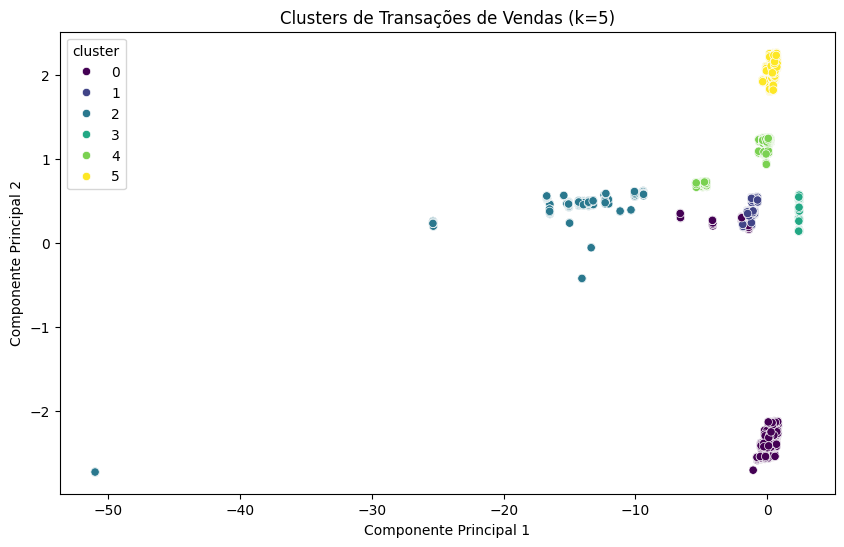

In [79]:
# Usa PCA para reduzir a dimensionalidade para visualização
pca = sk_PCA(n_components=2)
pca_features = [list(row) for row in result_df['pca_features']]
principal_components = pca.fit_transform(pca_features)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['cluster'] = result_df['cluster']

# Visualização
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=df_pca)
plt.title(f'Clusters de Transações de Vendas (k={k})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

## Interpretação dos Clusters baseada na Distribuição das Features

In [52]:
predictions_df = predictions.select(
    'cluster', 
    'hour_of_day', 
    'day_of_week', 
    'product_category', 
    'transaction_qty', 
    'unit_price', 
    'total_value').toPandas()


24/07/28 19:28:15 WARN TaskSetManager: Stage 1776 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


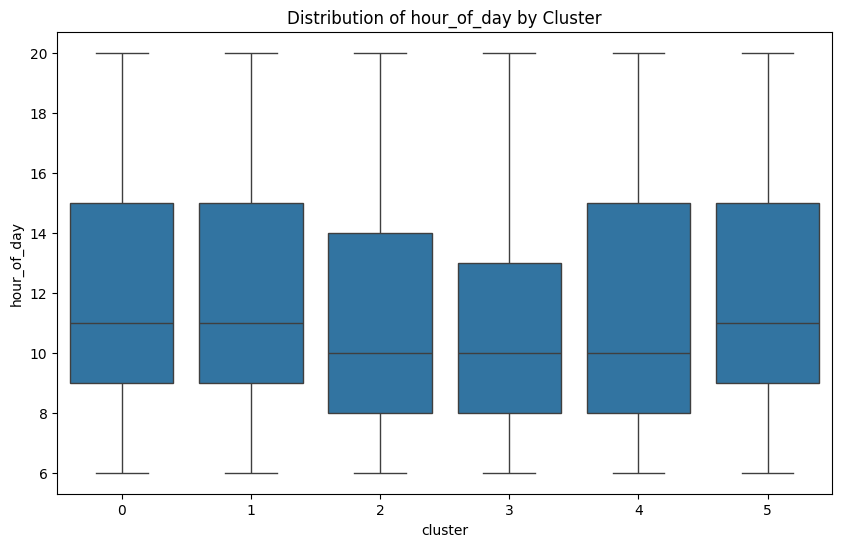

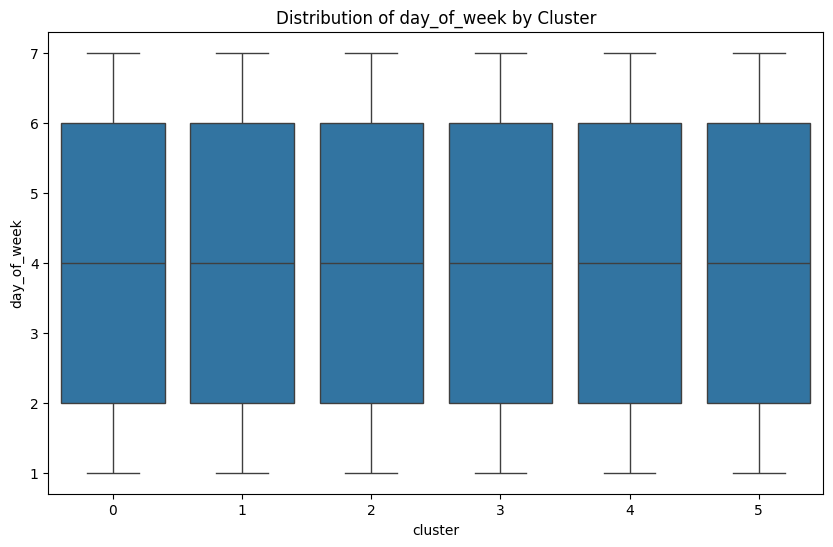

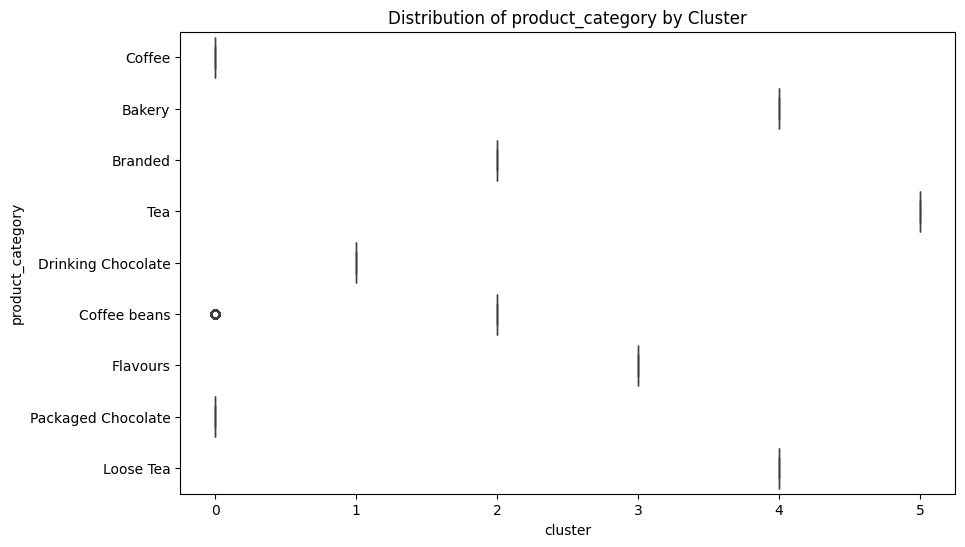

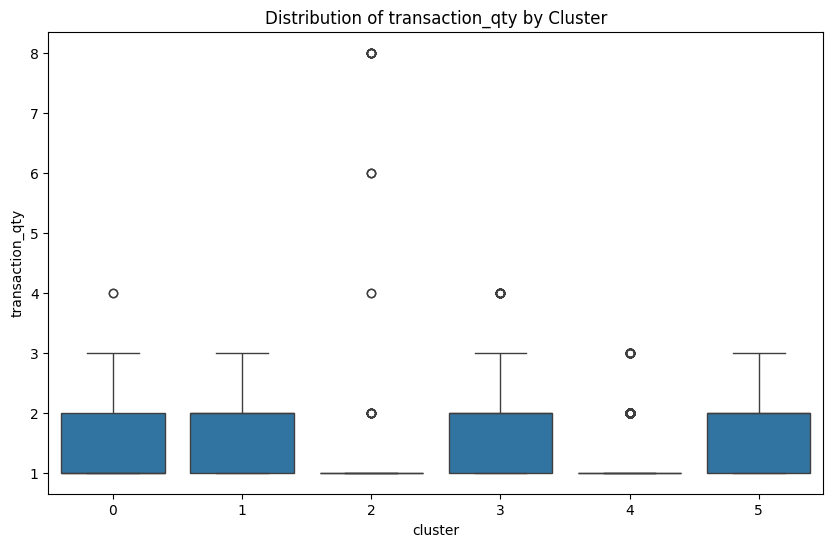

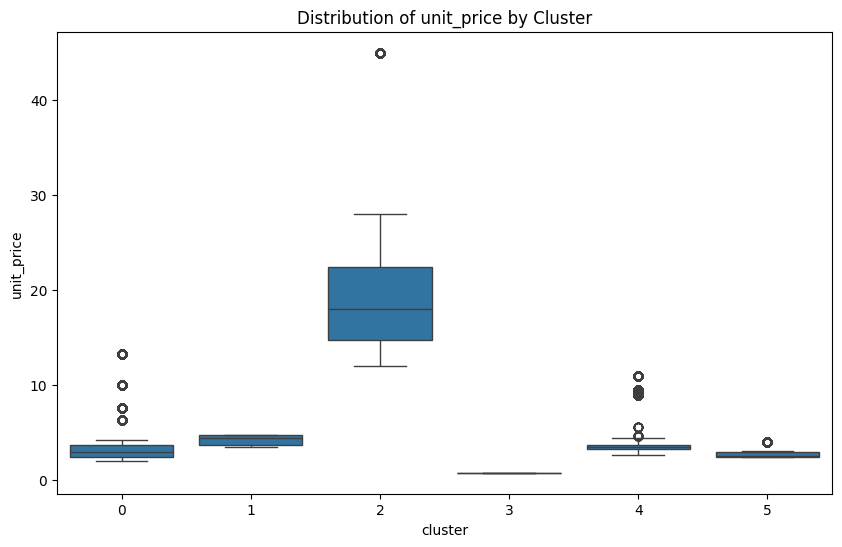

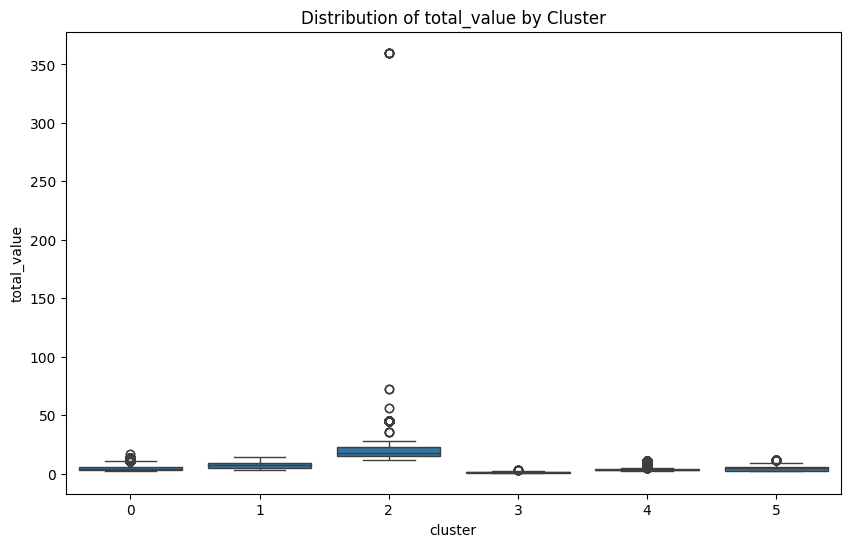

In [53]:
# Plotar a distribuição das features por cluster
for feature in ['hour_of_day', 'day_of_week', 'product_category', 'transaction_qty', 'unit_price', 'total_value']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=predictions_df)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

In [74]:
for k in range(6):
    print('=='*20)
    print('Cluster=',k)
    cluster_df = predictions_df[predictions_df['cluster']==k]
    total_sales = len(cluster_df)
    category_counts = cluster_df[['product_category']].value_counts()
    category_percentage = (category_counts / total_sales) * 100
    print(category_percentage)

Cluster= 0
product_category  
Coffee                98.948117
Packaged Chocolate     0.824906
Coffee beans           0.226976
Name: count, dtype: float64
Cluster= 1
product_category  
Drinking Chocolate    100.0
Name: count, dtype: float64
Cluster= 2
product_category
Coffee beans        68.427726
Branded             31.572274
Name: count, dtype: float64
Cluster= 3
product_category
Flavours            100.0
Name: count, dtype: float64
Cluster= 4
product_category
Bakery              94.959593
Loose Tea            5.040407
Name: count, dtype: float64
Cluster= 5
product_category
Tea                 100.0
Name: count, dtype: float64


In [60]:
for k in range(6):
    print('Cluster=',k)
    print(predictions_df[predictions_df['cluster']==k].describe())

Cluster= 0
       cluster   hour_of_day   day_of_week  transaction_qty    unit_price  \
count  59037.0  59037.000000  59037.000000     59037.000000  59037.000000   
mean       0.0     11.861290      3.993072         1.522283      3.089197   
std        0.0      3.761333      1.990229         0.551008      0.967151   
min        0.0      6.000000      1.000000         1.000000      2.000000   
25%        0.0      9.000000      2.000000         1.000000      2.500000   
50%        0.0     11.000000      4.000000         1.000000      3.000000   
75%        0.0     15.000000      6.000000         2.000000      3.750000   
max        0.0     20.000000      7.000000         4.000000     13.330000   

        total_value  
count  59037.000000  
mean       4.669954  
std        2.065368  
min        2.000000  
25%        3.000000  
50%        4.250000  
75%        6.000000  
max       17.000000  
Cluster= 1
       cluster   hour_of_day   day_of_week  transaction_qty    unit_price  \
count  11

### Análise dos Clusters:
#### Cluster 0:
- Quantidade de Transações: 59.037
- Hora do Dia: Média de 11.86 (pico ao redor do meio-dia)
- Dia da Semana: Distribuição uniforme
- Quantidade de Transação: Média de 1.52 itens por transação
- Preço Unitário: Média de 3.09
- Valor Total: Média de 4.67
- Categoria de Produto: Coffee (98,9%), Packaged Chocolate (0.8%), Coffee beans (0.2%)
  
#### Cluster 1
- Quantidade de Transações: 11.468
- Hora do Dia: Média de 11.92 (pico ao redor do meio-dia)
- Dia da Semana: Distribuição uniforme
- Quantidade de Transação: Média de 1.52 itens por transação
- Preço Unitário: Média de 4.15
- Valor Total: Média de 6.31
- Categoria de Produto: Drinking Chocolate (100%)

#### Cluster 2
- Quantidade de Transações: 2.366
- Hora do Dia: Média de 11.05
- Dia da Semana: Distribuição uniforme
- Quantidade de Transação: Média de 1.04 itens por transação
- Preço Unitário: Média de 20.60
- Valor Total: Média de 22.13
- Categoria de Produto: Coffee beans (68.4%) e Branded (31.5%)

#### Cluster 3
- Quantidade de Transações: 6.790
- Hora do Dia: Média de 10.71
- Dia da Semana: Distribuição uniforme
- Quantidade de Transação: Média de 1.55 itens por transação
- Preço Unitário: Média de 0.80
- Valor Total: Média de 1.24
- Categoria de Produto: Flavours (100.0%)

#### Cluster 4
- Quantidade de Transações: 24.006
- Hora do Dia: Média de 11.45
- Dia da Semana: Distribuição uniforme
- Quantidade de Transação: Média de 1.02 itens por transação
- Preço Unitário: Média de 3.84
- Valor Total: Média de 3.90
- Categoria de Produto: Bakery (94.9%) e Loose Tea (5%)

#### Cluster 5
- Quantidade de Transações: 45.449
- Hora do Dia: Média de 11.86
- Dia da Semana: Distribuição uniforme
- Quantidade de Transação: Média de 1.53 itens por transação
- Preço Unitário: Média de 2.82
- Valor Total: Média de 4.32
- Categoria de Produto: Tea (100%)

In [82]:
# Salva o DataFrame Spark em um arquivo CSV
predictions.select('transaction_id', 'cluster').coalesce(1).write.csv('../clusters_result', header=True)

24/07/29 21:42:13 WARN TaskSetManager: Stage 1785 contains a task of very large size (2523 KiB). The maximum recommended task size is 1000 KiB.
